No checkpoint found for joint_input_separate_pooling/MINT, fold 0
No checkpoint found for joint_input_separate_pooling/MINT, fold 1
No checkpoint found for joint_input_separate_pooling/MINT, fold 2
No checkpoint found for joint_input_separate_pooling/MINT, fold 3
No checkpoint found for joint_input_separate_pooling/MINT, fold 4
No checkpoint found for joint_input_separate_pooling/MINT, fold 0
No checkpoint found for joint_input_separate_pooling/MINT, fold 1
No checkpoint found for joint_input_separate_pooling/MINT, fold 2
No checkpoint found for joint_input_separate_pooling/MINT, fold 3
No checkpoint found for joint_input_separate_pooling/MINT, fold 4
No checkpoint found for joint_input_separate_pooling/MINT, fold 0
No checkpoint found for joint_input_separate_pooling/MINT, fold 1
No checkpoint found for joint_input_separate_pooling/MINT, fold 2
No checkpoint found for joint_input_separate_pooling/MINT, fold 3
No checkpoint found for joint_input_separate_pooling/MINT, fold 4
No checkpo

<Figure size 3840x2880 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

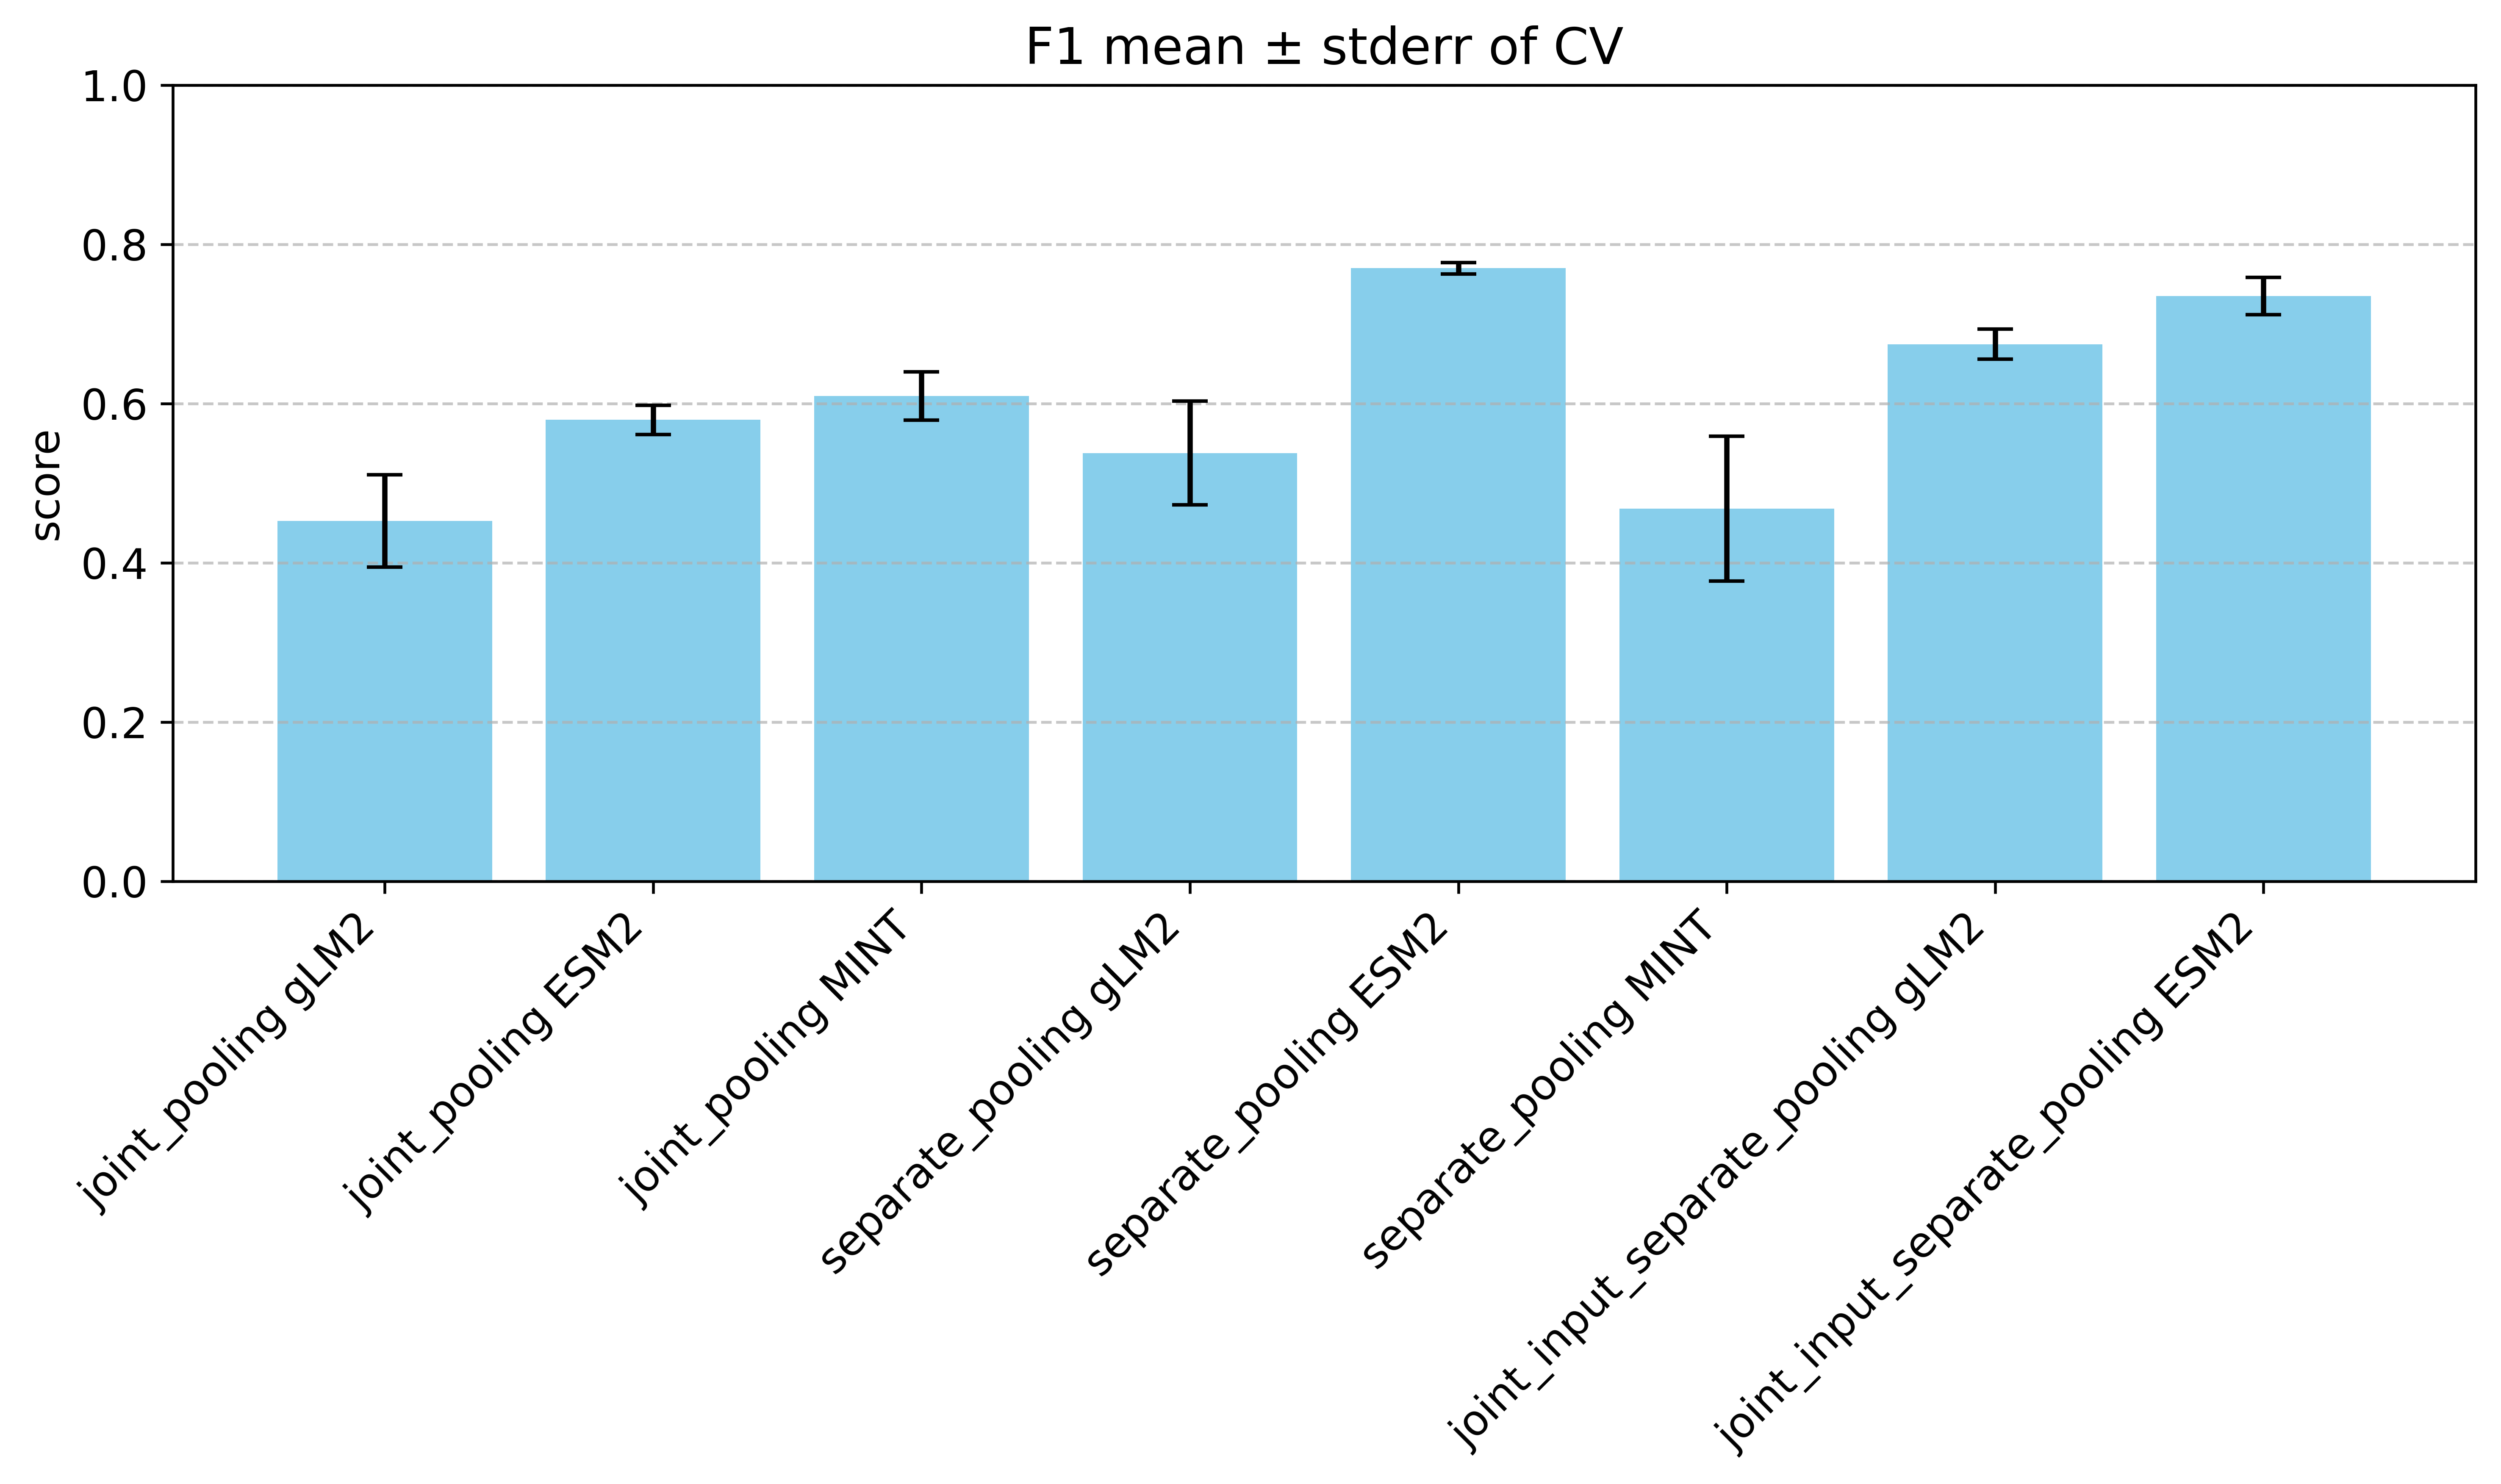

In [7]:
from Evaluator import Evaluator

evaluator = Evaluator(
    base_dir="/scicore/home/schwede/pudziu0000/projects/gLM/logs/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/", 
    representations=["joint_pooling", "separate_pooling", "joint_input_separate_pooling"],
    biolms=["gLM2", "ESM2", "MINT"],
    dev_stage="CV",
    num_folds=5, 
    out_dir=f"/scicore/home/schwede/pudziu0000/projects/gLM/outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/",
    hyperparam="batch_size", hyperparam_value=16)

evaluator.run()

parent_dir = "Adam"
evaluator.rename_logs(parent_dir)

No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate
No checkpoint found for joint_input_separate_pooling/MINT, fold train_validate


<Figure size 3840x2880 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

<Figure size 6000x3600 with 0 Axes>

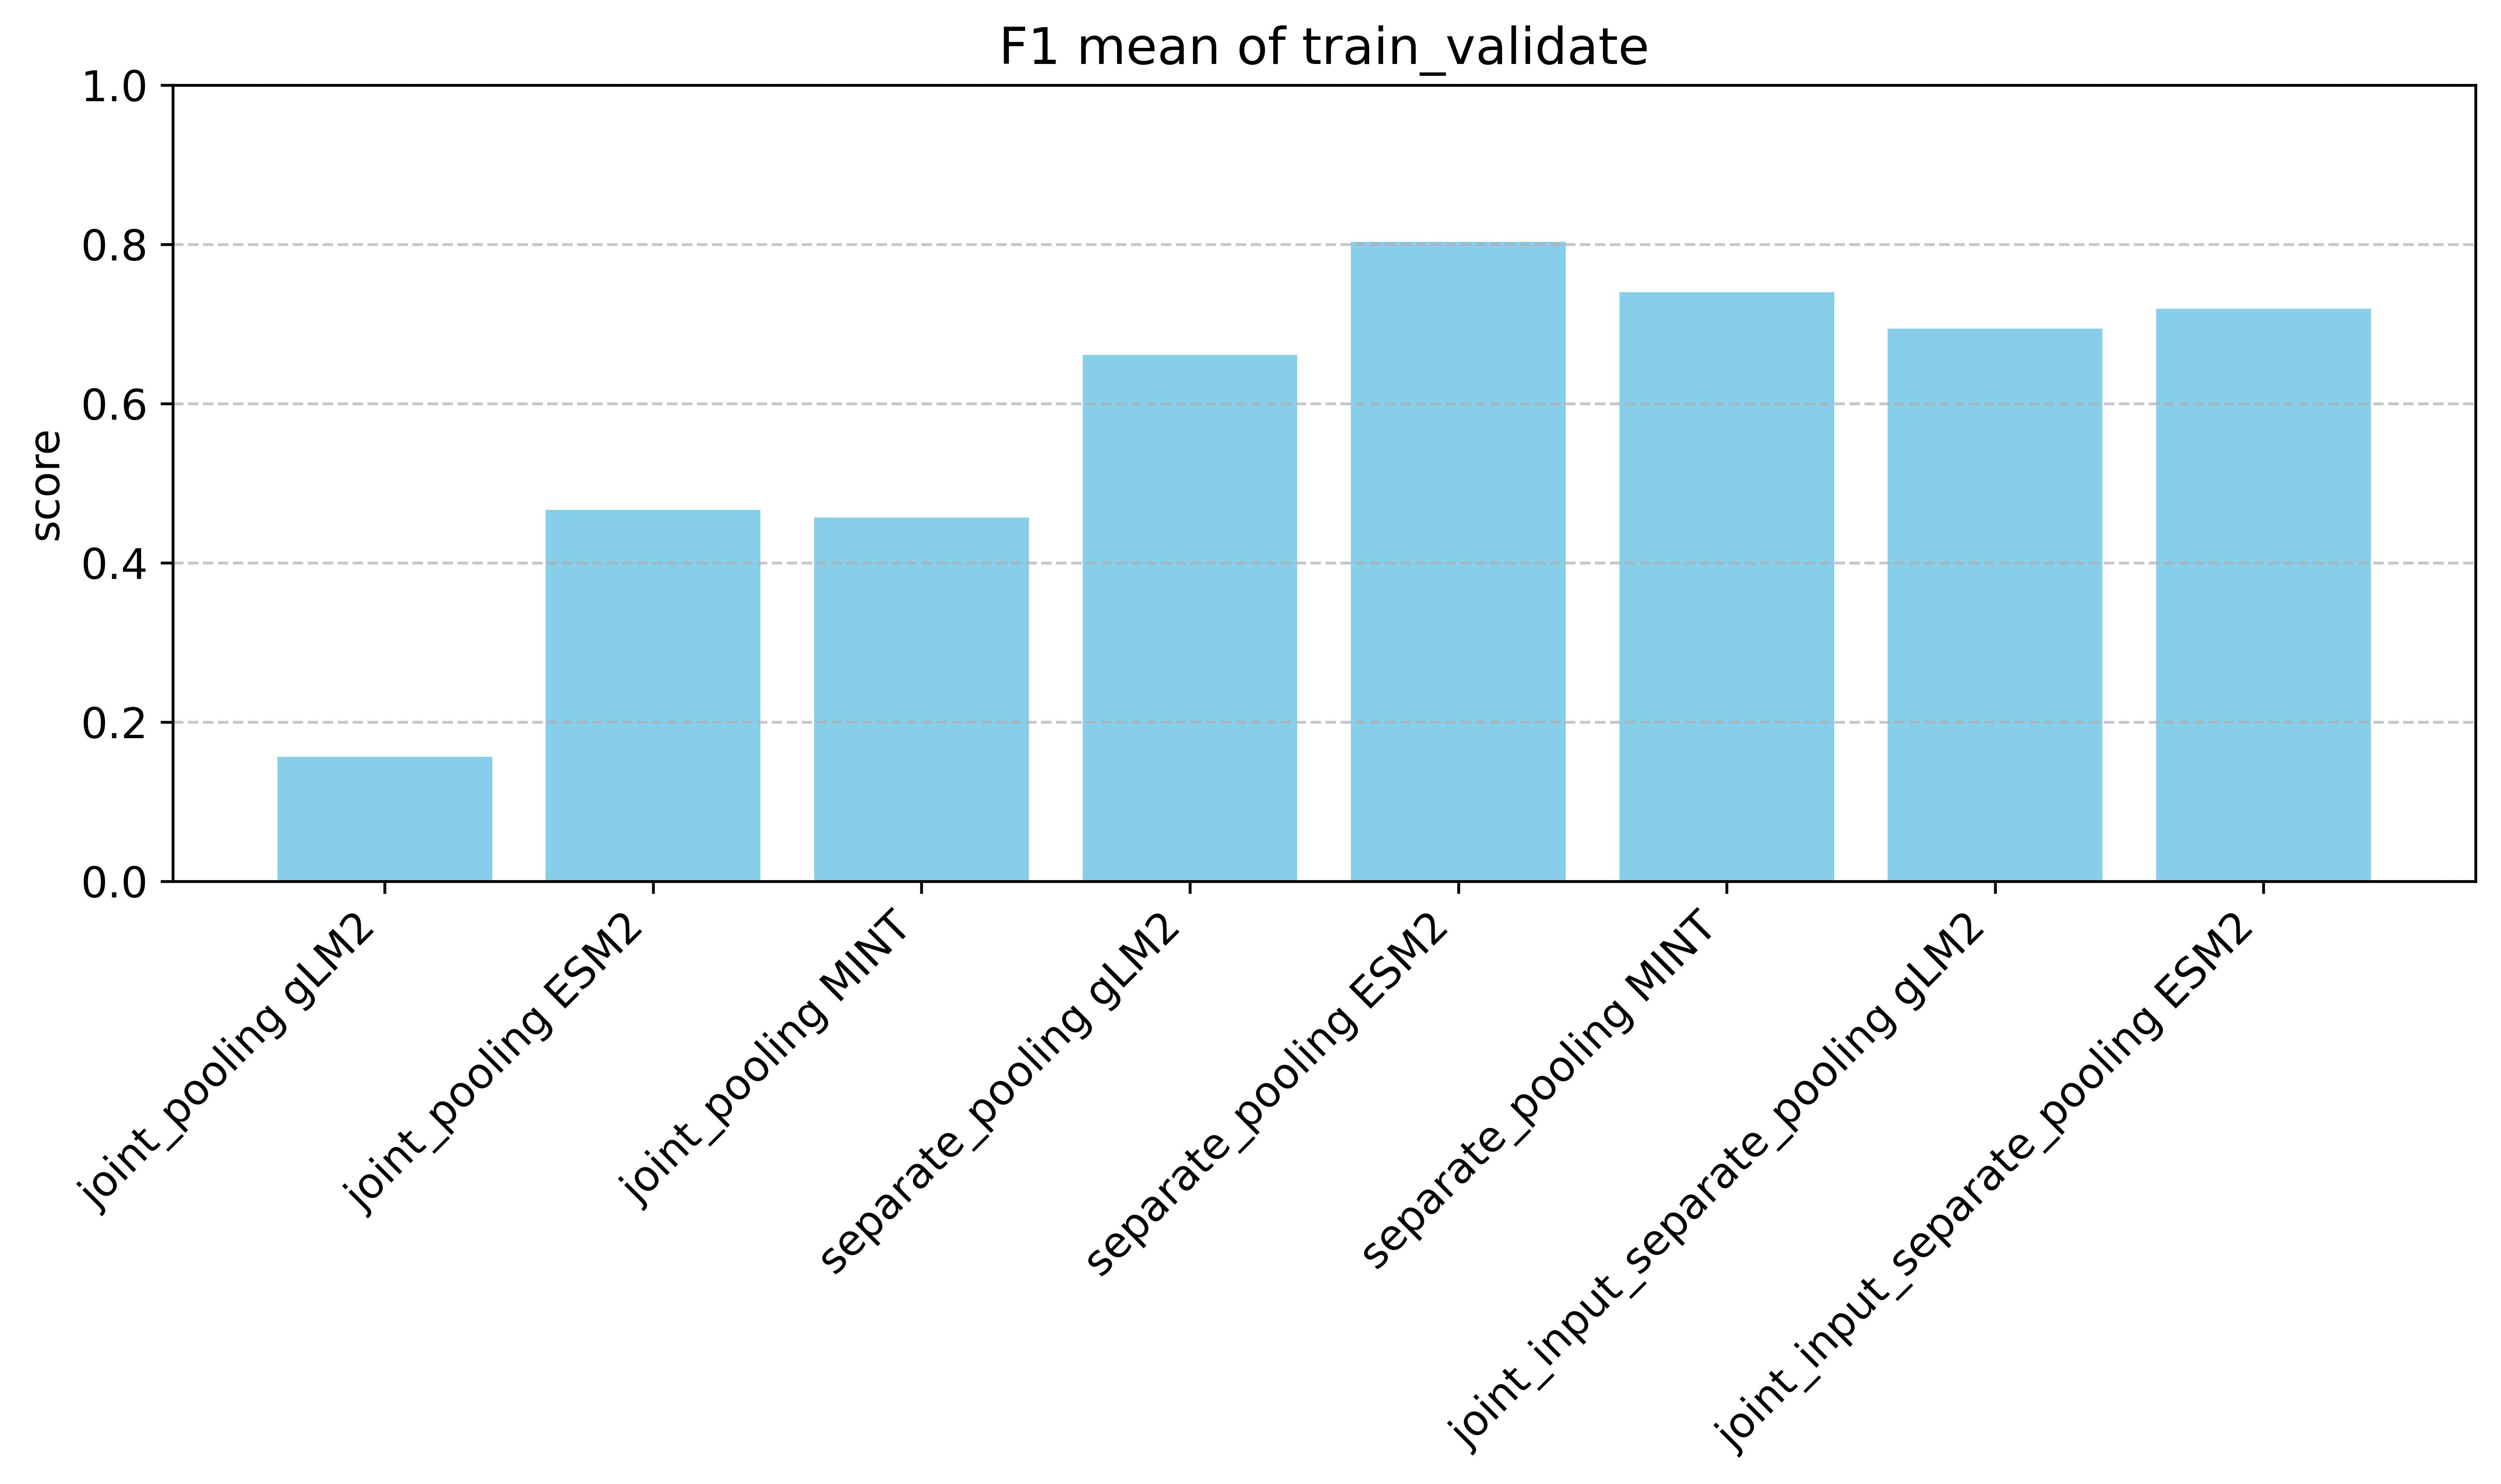

In [8]:
from Evaluator import Evaluator

# train_validate stage after CV

evaluator = Evaluator(
    base_dir="/scicore/home/schwede/pudziu0000/projects/gLM/logs/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/", 
    representations=["joint_pooling", "separate_pooling", "joint_input_separate_pooling"],
    biolms=["gLM2", "ESM2", "MINT"],
    dev_stage="train_validate",
    num_folds=1, 
    out_dir=f"/scicore/home/schwede/pudziu0000/projects/gLM/outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/",
    hyperparam="", hyperparam_value="")

evaluator.run()

In [126]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from glob import glob

def extract_batch_size_from_path(path):
    match = re.search(r"batch_size_(\d+)", path)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Could not extract batch size from path: {path}")

def adjust_axis(metric, x_tick_labels):
    plt.xticks(x_tick_labels)
    if(metric == "mcc"):
        plt.ylim((-1, 1.1))
    elif(metric in ["accuracy", "pr_auc", "roc_auc"]):
        plt.ylim((0, 1.1))

def adjust_title(metric, biolm):
    if(metric == "mcc"):
        plt.title(f"Cross-validation's {metric_name.upper()} across batch sizes for {biolm}")
    elif(metric == "accuracy"):
        plt.title(f"Cross-validation's {metric_name.capitalize()} across batch sizes for {biolm}")
    elif(metric == "pr_auc" or metric == "roc_auc"):
        plt.title(f"Cross-validation's {metric_name.replace('_', ' ').upper()} across batch sizes for {biolm}")

def get_colour_map():
    representations = ['joint-pooling', 'separate-pooling', 'joint-input-separate-pooling']
    palette = ["#7E2E84", "#47A8BD", "#EC0B43"]
    colour_map = {
        rep: color
        for rep, color in zip(representations, palette)
    }
    return colour_map
    

def plot_metric_across_batch_sizes(
    data_dir,
    metric_name,
    selected_biolm,
    output_path="plot.png"
):
    # Collect all metrics.csv files recursively
    csv_files = sorted(glob(os.path.join(data_dir, "**/metrics.csv"), recursive=True))

    all_data = []

    for file in csv_files:
        try:
            batch_size = extract_batch_size_from_path(file)
        except ValueError as e:
            print(e)
            continue

        df = pd.read_csv(file)
        df["batch_size"] = batch_size
        all_data.append(df)

    if not all_data:
        raise RuntimeError("No valid data loaded. Check the file paths and structure.")

    df_all = pd.concat(all_data, ignore_index=True)

    # Filter for the selected BioLM
    df_biolm = df_all[df_all["biolm"] == selected_biolm]

    if df_biolm.empty:
        raise ValueError(f"No entries found for BioLM '{selected_biolm}' in provided files.")

    # Compute mean and SEM
    summary = (
        df_biolm
        .groupby(["batch_size", "representation"])[metric_name]
        .agg(["mean", "sem"])
        .reset_index()
    )

    # Plotting
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6), dpi=200)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(0.5)
    sns.set_context("notebook", font_scale=1.5)
    colour_map = get_colour_map()

    for rep in summary["representation"].unique():
        data = summary[summary["representation"] == rep].sort_values("batch_size")
        representation = rep.replace("_", "-")
        plt.plot(data["batch_size"], data["mean"], marker="o", 
                 label=representation, 
                 color=colour_map[representation]
        )
        plt.fill_between(
            data["batch_size"],
            data["mean"] - data["sem"],
            data["mean"] + data["sem"],
            alpha=0.2,
            color=colour_map[representation]
        )

    adjust_title(metric_name, selected_biolm)
    plt.xlabel("batch size")
    plt.ylabel("score")
    adjust_axis(metric_name, data["batch_size"])
    plt.legend(title="Representation")
    plt.tight_layout()
    plt.grid(True, alpha=0.8, linestyle="--", linewidth=0.5)
    plt.savefig(output_path, dpi=200)
    plt.show()

    


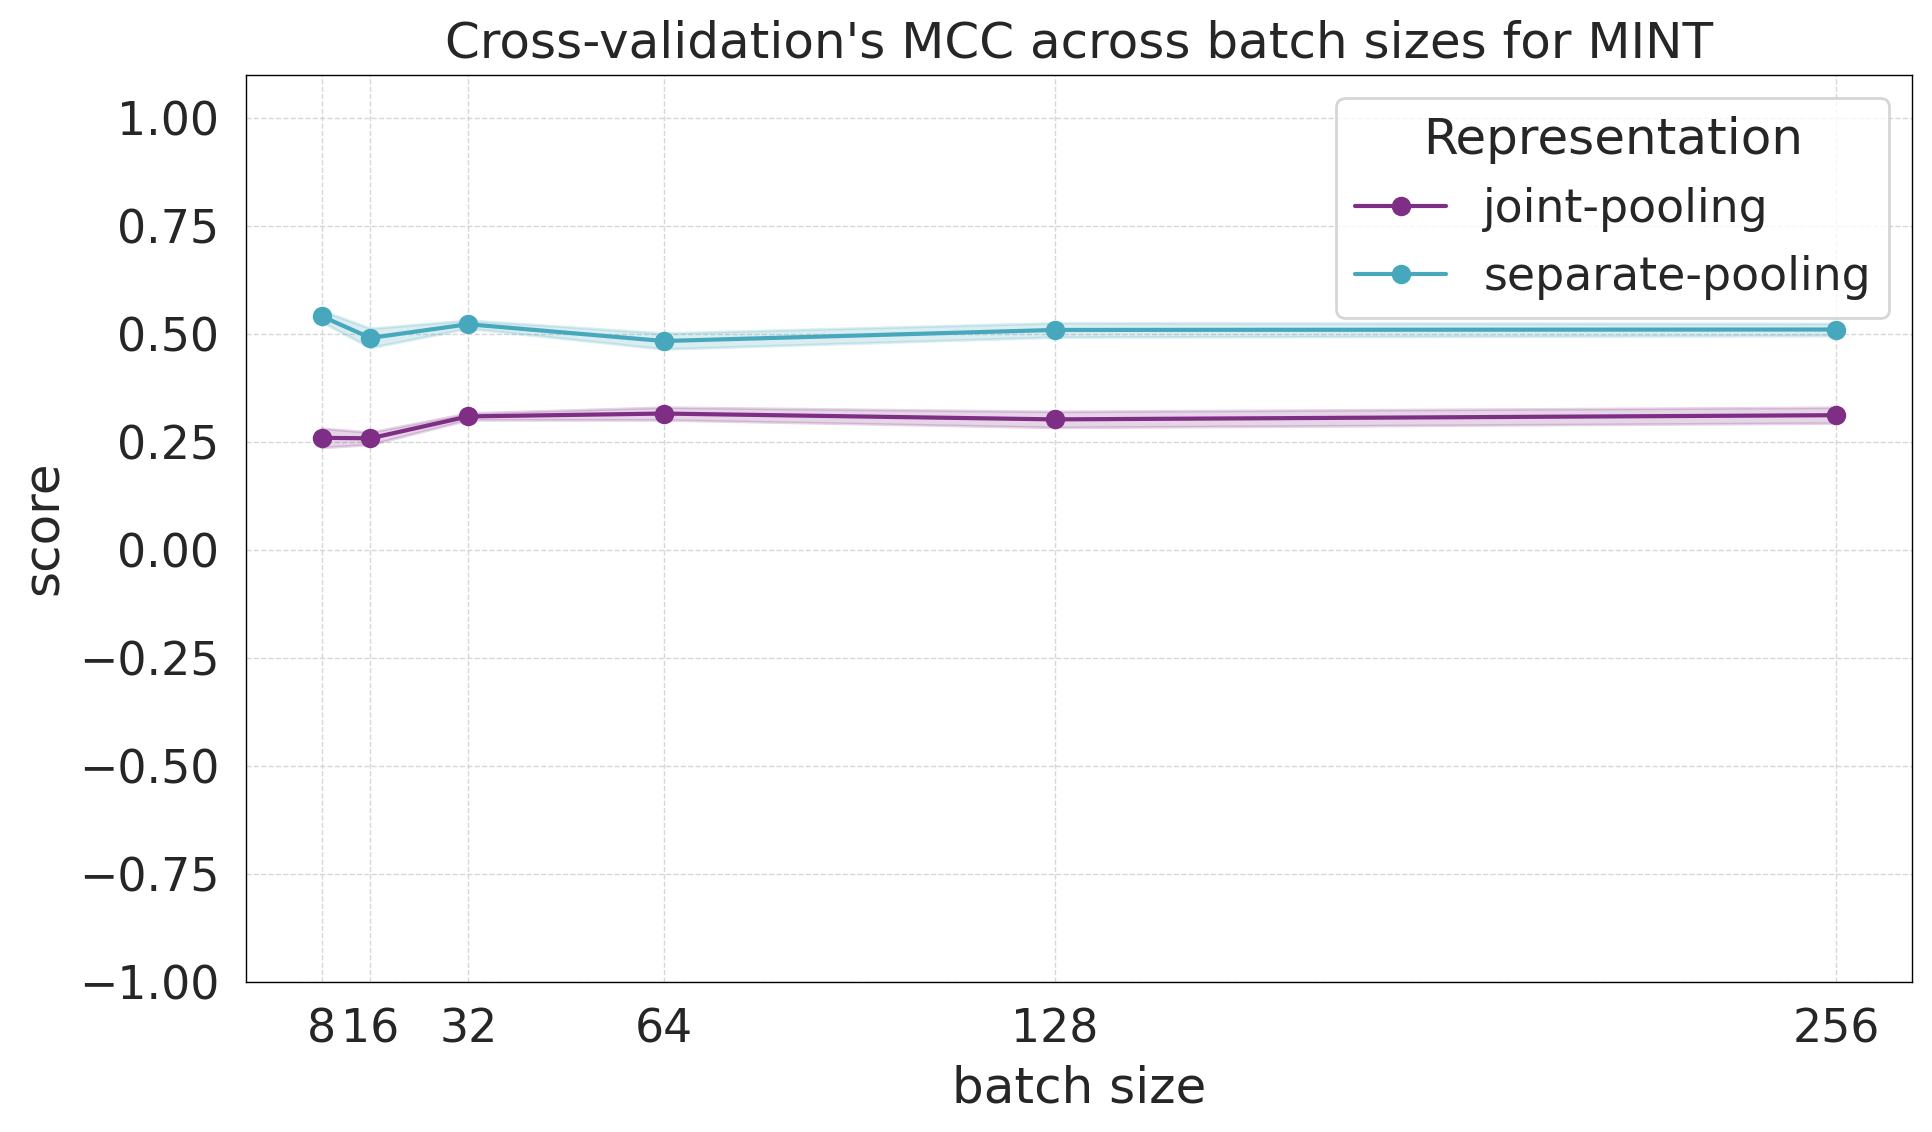

In [129]:
biolm="MINT"
metric_name="mcc"

plot_metric_across_batch_sizes(
    data_dir="../outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/optimizer_AdamW/",
    metric_name=metric_name,
    selected_biolm=biolm,
    output_path=f"../outputs/predictions/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/optimizer_AdamW/{metric_name}_{biolm}_batch_sizes.png"
)